In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import Resize, ToTensor, Normalize, transforms
from torchvision.datasets import ImageFolder
import shutil

## Slice With Floder

In [2]:
original_dataset_dir = './input/data/train/images'
base_dir = './splitted'
classes_list = ["{0:02d}".format(a) for a in range(18)]

if not os.path.isdir(base_dir): 
    os.makedirs(base_dir)

train_dir = os.path.join(base_dir, 'train')
if not os.path.isdir(train_dir): 
    os.makedirs(train_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.isdir(test_dir):
    os.makedirs(test_dir)

for classes in classes_list:
    train_split = os.path.join(train_dir, str(classes))
    if not os.path.isdir(train_split):
        os.mkdir(train_split)
    test_split = os.path.join(test_dir, str(classes))
    if not os.path.isdir(test_split):
        os.mkdir(test_split)
    

![nn](classes.png)

In [3]:
def what_is_this(file):
    target = -1

    # 마스크 여부 분류
    if 'incorrect' in file:
        target += 7
    elif 'mask' in file:
        target += 1
    else: # not wear
        target += 13

    # 성별 분류
    if data['gender'] == 'male':
        target += 0
    else: # female
        target += 3

    # 나이 분류
    if data['age'] < 30:
        target += 0
    elif data['age'] >= 60:
        target += 2
    else: # 30 ~ 60
        target += 1
    
    return target


In [4]:
from zlib import crc32

def ratio_splitter(identifier, test_ratio):
    return crc32(np.string_(identifier)) & 0xffffffff < test_ratio * 2 ** 32

In [20]:
data_infos = pd.read_csv("./input/data/train/train.csv")
train_counter = {}
test_counter = {}

for i in range(18):
    train_counter[str(i)] = 0
    test_counter[str(i)] = 0

for row in data_infos.iterrows():
    data_num, data = row[0], row[1]

    # 목표 디렉토리 설정
    path = os.path.join(original_dataset_dir, data['path'])
    # 디렉토리 리스트 가져오기
    fnames = os.listdir(path)

    for file in fnames:
        if file[0] == '.':
            continue

        target_class = what_is_this(file)
        target_path = "{0:02d}".format(target_class)
        
        src = os.path.join(path, file)
        test_set_check = ratio_splitter(src, 0.2)

        if test_set_check:
            dst = os.path.join(os.path.join(test_dir, target_path), file)
        else: # train_set
            dst = os.path.join(os.path.join(train_dir, target_path), file)

        shutil.copyfile(src, dst)

        # 파일 확장자를 추출하기 위해서
        name, extension = file.split(".") 

        if test_set_check:
            change_name = os.path.join(os.path.join(test_dir, target_path), str(test_counter[str(target_class)]) + "." + extension)
            test_counter[str(target_class)] += 1 
        else: # train_set
            change_name = os.path.join(os.path.join(train_dir, target_path), str(train_counter[str(target_class)]) + "." + extension)
            train_counter[str(target_class)] += 1 
            
        shutil.move(dst, change_name)



In [21]:
import cv2
import albumentations as A

class Color:

    HueSaturationValue_isChecked = False
    RGBShift_isChecked = True

    #입력 이미지의 색조, 채도 및 값을 임의로 변경합니다.
    def HueSaturationValue (image, hue_shift_limit=30, sat_shift_limit=40, val_shift_limit=50, always_apply=False, p=1):
        """
       hue_shift_limit	[int, int] or int	
        색조 변경 범위. hue_shift_limit가 단일 int이면 범위는 (-hue_shift_limit, hue_shift_limit)입니다. 기본값 : (-20, 20).

        sat_shift_limit	[int, int] or int	
        채도 변경 범위. sat_shift_limit가 단일 정수이면 범위는 (-sat_shift_limit, sat_shift_limit)입니다. 기본값 : (-30, 30).

        val_shift_limit	[int, int] or int	
        값 변경 범위. val_shift_limit가 단일 정수이면 범위는 (-val_shift_limit, val_shift_limit)입니다. 기본값 : (-20, 20).

        p	float	
        변환을 적용 할 확률. 기본값 : 1
        """
        transform = A.Compose([
            A.HueSaturationValue(hue_shift_limit, sat_shift_limit, val_shift_limit, always_apply, p)
        ],p=1)
        img = transform(image=image)['image']
        return img

In [22]:
def image_save(directory, image_data, image_name, excution):
    cv2.imwrite(os.path.join(directory, str(image_name) + "." + excution), image_data)

In [23]:
over_sixty_list = ["02", "05", "08", "11", "14", "17"]
not_mask_list = ["06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17"]
mans_list = ["00", "01", "02", "06", "07", "08", "12", "13", "14"]

over_sixty_ratio = 6
not_mask_ratio = 5
mans_ratio = 0.6

### Over Sixty data augmentation

In [24]:
for dir in over_sixty_list:
    target_class = int(dir)
    train_target = os.path.join(train_dir, dir)
    test_target = os.path.join(test_dir, dir)

    # 디렉토리 리스트 가져오기
    train_fnames = os.listdir(train_target)
    test_fnames = os.listdir(test_target)
    
    for train_file in train_fnames:
        for _ in range(over_sixty_ratio):           
            aug_img = cv2.imread(os.path.join(train_target, train_file))
            aug_img = Color.HueSaturationValue(aug_img)
            _, extension = train_file.split(".") 
            image_save(train_target, aug_img, train_counter[str(target_class)], extension)
            train_counter[str(target_class)] += 1

    for test_file in test_fnames:
        for _ in range(over_sixty_ratio):           
            aug_img = cv2.imread(os.path.join(test_target, test_file))
            aug_img = Color.HueSaturationValue(aug_img)
            _, extension = test_file.split(".") 
            image_save(test_target, aug_img, test_counter[str(target_class)], extension)
            test_counter[str(target_class)] += 1

        

### not wearing mask augmentation

In [25]:
for dir in not_mask_list:
    target_class = int(dir)
    train_target = os.path.join(train_dir, dir)
    test_target = os.path.join(test_dir, dir)

    # 디렉토리 리스트 가져오기
    train_fnames = os.listdir(train_target)
    test_fnames = os.listdir(test_target)
    
    for train_file in train_fnames:
        for _ in range(not_mask_ratio):           
            aug_img = cv2.imread(os.path.join(train_target, train_file))
            aug_img = Color.HueSaturationValue(aug_img)
            _, extension = train_file.split(".") 
            image_save(train_target, aug_img, train_counter[str(target_class)], extension)
            train_counter[str(target_class)] += 1

    for test_file in test_fnames:
        for _ in range(not_mask_ratio):           
            aug_img = cv2.imread(os.path.join(test_target, test_file))
            aug_img = Color.HueSaturationValue(aug_img)
            _, extension = test_file.split(".") 
            image_save(test_target, aug_img, test_counter[str(target_class)], extension)
            test_counter[str(target_class)] += 1

        

### Male, Female Data Augmentation

In [26]:
for dir in mans_list:
    target_class = int(dir)
    train_target = os.path.join(train_dir, dir)
    test_target = os.path.join(test_dir, dir)

    # 디렉토리 리스트 가져오기
    train_fnames = os.listdir(train_target)
    test_fnames = os.listdir(test_target)
    
    for train_file in train_fnames:
        target_image_path = os.path.join(train_target, train_file)
        if ratio_splitter(target_image_path, mans_ratio):      
            aug_img = cv2.imread(target_image_path)
            aug_img = Color.HueSaturationValue(aug_img)
            _, extension = train_file.split(".") 
            image_save(train_target, aug_img, train_counter[str(target_class)], extension)
            train_counter[str(target_class)] += 1

    for test_file in test_fnames:
        target_image_path = os.path.join(test_target, test_file)
        if ratio_splitter(target_image_path, mans_ratio):         
            aug_img = cv2.imread(target_image_path)
            aug_img = Color.HueSaturationValue(aug_img)
            _, extension = test_file.split(".") 
            image_save(test_target, aug_img, test_counter[str(target_class)], extension)
            test_counter[str(target_class)] += 1

### Start Learnging

In [8]:
USE_CUDA = torch.cuda.is_available
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print(DEVICE)
BATCH_SIZE = 300
EPOCH = 50
transform_base = transforms.Compose([transforms.Resize((287, 287)),transforms.ToTensor()])

cuda


In [28]:
train_dataset = ImageFolder(root = "./splitted/train", transform = transform_base)
val_dataset = ImageFolder(root = "./splitted/test", transform = transform_base)

train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle = True, num_workers=4)

### check all class is correct

In [29]:
import matplotlib.pyplot as plt

train_dataset.class_to_idx

{'00': 0,
 '01': 1,
 '02': 2,
 '03': 3,
 '04': 4,
 '05': 5,
 '06': 6,
 '07': 7,
 '08': 8,
 '09': 9,
 '10': 10,
 '11': 11,
 '12': 12,
 '13': 13,
 '14': 14,
 '15': 15,
 '16': 16,
 '17': 17}

In [30]:
from collections import Counter

print(dict(Counter(train_dataset.targets)))

{0: 3553, 1: 2617, 2: 3757, 3: 2925, 4: 3261, 5: 2989, 6: 4228, 7: 3114, 8: 4503, 9: 3504, 10: 3984, 11: 3612, 12: 4100, 13: 3137, 14: 4368, 15: 3642, 16: 3852, 17: 3276}


# Custom Model *Dont use

![nn](cnn.jpg)

In [6]:
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 3, padding= 1)
        self.conv2 = nn.Conv2d(256, 128, 3, padding= 1)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.AdaptiveAvgPool2d(2)
        self.residual_block1= nn.Sequential(
            nn.Conv2d(128, 128, 1),
            nn.Conv2d(128, 128, 3, padding= 1),
        )
        self.conv3 = nn.Conv2d(128, 64, 3, padding= 1)
        self.residual_block2= nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.Conv2d(64, 64, 3, padding= 1),
        )
        self.conv4 = nn.Conv2d(64, 32, 3, padding= 1)
        self.residual_block3 = nn.Sequential(
            nn.Conv2d(32, 32, 1),
            nn.Conv2d(32, 32, 3, padding= 1),
        )
        self.conv5 = nn.Conv2d(32, 16, 3, padding= 1)
        self.residual_block4 = nn.Sequential(
            nn.Conv2d(16, 16, 1),
            nn.Conv2d(16, 16, 3, padding= 1),
        )
        self.conv6 = nn.Conv2d(16, 8, 3, padding= 1)
        self.residual_block5 = nn.Sequential(
            nn.Conv2d(8, 8, 1),
            nn.Conv2d(8, 8, 3, padding = 1),
        )
        self.flatten = nn.Flatten()
        # 분류 용
        self.fc1 = nn.Linear(32, 18)
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        
        for _ in range(1):
            x = self.residual_block1(x)
        x = self.conv3(x)
        x = self.pool1(x)
        for _ in range(2):
            x = self.residual_block2(x)
        x = self.conv4(x)
        x = self.pool1(x)
        for _ in range(8):
            x = self.residual_block3(x)
        x = self.conv5(x)
        x = self.pool1(x)
        for _ in range(8):
            x = self.residual_block4(x)
        x = self.conv6(x)
        x = self.pool1(x)
        for _ in range(4):
            x = self.residual_block5(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)


        return F.log_softmax(x, dim = 1)

model_base = Net().to(DEVICE)
optimizer = optim.Adam(model_base.parameters(), lr = 0.001)

# Training

### 학습 함수

In [5]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

### 평가 함수

In [6]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction = "sum").item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
   
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.0 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [2]:
import time
import copy

def train_baseline(model, train_loader, val_loader, optimizer, num_epoches = 30):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(1, num_epoches + 1):
        since = time.time()
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader)
        val_loss, val_acc = evaluate(model, val_loader)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since

        print('+-+-++-+-++-+-++-+-+ epoch {} +-+-++-+-++-+-++-+-+'.format(epoch))

        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))
        print('val loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    model.load_state_dict(best_model_wts)
    return model



In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([170, 128]),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
         transforms.Resize([170, 128]),
         transforms.ToTensor()
    ])
}

train_dataset = ImageFolder(root = "./splitted/train", transform = data_transforms['train'])
val_dataset = ImageFolder(root = "./splitted/test", transform = data_transforms['val'])

image_datasets = {
    'train' : train_dataset,
    'val' : val_dataset
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=False, num_workers=4) for x in ['train', 'val']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes['train'])
print(dataset_sizes['val'])


64422
16760


In [10]:
from torchvision import models
import torch.optim as optim

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 18)
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr = 0.001)

from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
# Freeeeze
ct = 0
for child in resnet.children():
    ct+= 1
    if ct< 6:
        for param in child.parameters():
            param.requires_grad = False

In [12]:
import copy 
import time 


def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0  
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1)) 
        since = time.time()                                     
        for phase in ['train', 'val']: 
            if phase == 'train': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0  
            running_corrects = 0  
 
            
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)  
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)  
    
                    if phase == 'train':   
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)  
                running_corrects += torch.sum(preds == labels.data)  
            if phase == 'train':  
                scheduler.step()
 
            epoch_loss = running_loss/dataset_sizes[phase]  
            epoch_acc = running_corrects.double()/dataset_sizes[phase]  
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
 
          
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
        time_elapsed = time.time() - since  
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts) 
    return model

In [14]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)
torch.save(model_resnet50, 'resnet50.pt')

-------------- epoch 1 ----------------


KeyboardInterrupt: 

In [191]:
model = torch.load("./resnet50.pt")
model.eval()

correct = 0
wrong = 0
test_predictions = []
all_labels = []
for images, label in dataloaders["val"]:
    with torch.no_grad():
        images = images.to(DEVICE)
        pred = model(images)
        _, pred = torch.max(pred, 1) 
        test_predictions.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

for i in range(len(test_predictions)):
    if test_predictions[i] == all_labels[i]:
        correct += 1
    else:
        wrong += 1

print(correct)
print(wrong)

15986
475


In [12]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
check_dir = './input/data/eval'

In [13]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [14]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(check_dir, 'info.csv'))
image_dir = os.path.join(check_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform_test = transforms.Compose([
    transforms.Resize([170, 128]),
    transforms.ToTensor()
])

dataset_test = TestDataset(image_paths, transform_test)

loader_test = DataLoader(
    dataset_test,
    shuffle=False
)
    
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
model = torch.load("./baseline.pt")
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader_test:
    with torch.no_grad():
        images = images.to(DEVICE)
        pred = model(images)
        _, pred = torch.max(pred, 1) 
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(check_dir, 'submission.csv'), index=False)
print('inference is done!')

inference is done!


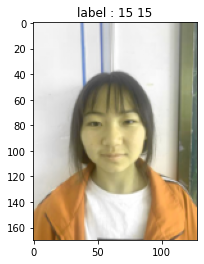

In [215]:
index = np.random.randint(0, len(val_dataset))
image, label = val_dataset.__getitem__(index)
plt.title("label : %s" % label + " " + str(test_predictions[index]))
plt.imshow(image.permute(1,2,0))
plt.show()

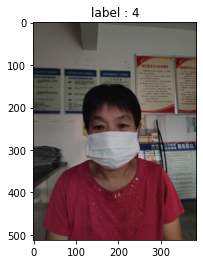

In [247]:
import matplotlib.pyplot as plt
import matplotlib.image as img

index = np.random.randint(0, len(image_paths))
image = img.imread(image_paths[index])
plt.title("label : %s" % all_predictions[index])
plt.imshow(image)
plt.show()